## Importação dos arquivos e geração dos segmentos

In [1]:
import os
import pandas as pd
import numpy as np
import pprint

# =============================================================================
# BLOCO 1: CONFIGURAÇÃO, CARREGAMENTO, DIVISÃO (80/20) E SEGMENTAÇÃO (CORRIGIDO)
# =============================================================================

# --- 1. CONFIGURAÇÕES GERAIS ---
caminho_raiz = r'C:\Users\vinic\OneDrive\Documentos\Graduação\TG\Dataset' # IMPORTANTE: Verifique se este caminho está correto
params_drive_end = {'n': 9, 'd': 0.3126, 'D': 1.537, 'phi_graus': 0.0}
TAXA_AMOSTRAL = 12000

# Dicionários de mapeamento
mapa_tipo_falha = {'IR': 'Pista Interna', 'B': 'Esfera', 'OR': 'Pista Externa', 'Normal': 'Normal'}
mapa_diametro_falha = {'7': '0.007"', '14': '0.014"', '21': '0.021"'}

# --- PARÂMETROS DE SEGMENTAÇÃO ---
tamanho_segmento = 4096
sobreposicao_percentual = 0.3
passo = int(tamanho_segmento * (1 - sobreposicao_percentual))

# --- 2. CARREGAMENTO, DIVISÃO E PROCESSAMENTO ---
dicionario_treino = {} # Dicionário para 80% dos dados normais
dicionario_teste = {} # Dicionário para 20% normais + 100% falhas reais

print(f"Iniciando a leitura e segmentação dos arquivos em '{caminho_raiz}'...")
print("Dados normais serão divididos (80% treino / 20% teste).")
print("Dados de falha real irão 100% para o teste.")

# Função auxiliar para segmentar um sinal e adicionar ao dicionário
def segmentar_e_adicionar(sinal, metadados, dicionario_alvo, chave_base):
    # Verifica se o sinal é longo o suficiente para pelo menos um segmento
    if len(sinal) < tamanho_segmento:
        # print(f"Aviso: Sinal da base '{chave_base}' muito curto ({len(sinal)} amostras) para gerar segmentos. Ignorando.")
        return 0

    num_segmentos_criados = 0
    for i, inicio in enumerate(range(0, len(sinal) - tamanho_segmento + 1, passo)):
        segmento = sinal[inicio : inicio + tamanho_segmento]
        df_segmento = pd.DataFrame({'amplitude': segmento})

        # Adiciona metadados
        df_segmento['arquivo_origem'] = metadados['nome_arquivo']
        df_segmento['rotacao_rpm'] = metadados['rpm']
        df_segmento['tipo_falha'] = metadados['tipo_falha']
        df_segmento['diametro_falha'] = metadados['diametro_falha']
        df_segmento['local_sensor'] = 'Drive End'

        chave_segmento = f"{chave_base}_seg_{i}"
        dicionario_alvo[chave_segmento] = df_segmento
        num_segmentos_criados += 1
    return num_segmentos_criados

# Loop principal pelos arquivos
for pasta_atual, _, arquivos in os.walk(caminho_raiz):
    for nome_arquivo in arquivos:
        # Processar apenas arquivos .npz
        if nome_arquivo.endswith('.npz'):
            caminho_completo = os.path.join(pasta_atual, nome_arquivo)

            # Decodificação de metadados
            nome_sem_ext = nome_arquivo.replace('.npz', '')
            partes = nome_sem_ext.split('_')
            rpm_str = partes[0]
            is_normal = 'Normal' in nome_arquivo

            metadados = {
                'nome_arquivo': nome_arquivo,
                'rpm': int(rpm_str) if rpm_str.isdigit() else 0,
                'tipo_falha': 'Normal' if is_normal else mapa_tipo_falha.get(partes[1].split('@')[0], 'Desconhecido'),
                'diametro_falha': 'N/A' if is_normal else mapa_diametro_falha.get(partes[2], 'Desconhecido')
            }

            try:
                dados_npz = np.load(caminho_completo)
                sensor_cod = 'DE' # Foco apenas no Drive End, como no seu código original

                if sensor_cod in dados_npz.files:
                    sinal_completo = dados_npz[sensor_cod].ravel()

                    if is_normal:
                        # DIVIDE O SINAL NORMAL EM 80/20
                        ponto_corte = int(len(sinal_completo) * 0.8)
                        sinal_treino = sinal_completo[:ponto_corte]
                        sinal_teste = sinal_completo[ponto_corte:]

                        chave_base_normal = f"{nome_sem_ext}_{sensor_cod}"
                        segmentar_e_adicionar(sinal_treino, metadados, dicionario_treino, f"{chave_base_normal}_treino")
                        segmentar_e_adicionar(sinal_teste, metadados, dicionario_teste, f"{chave_base_normal}_teste")

                    else:
                        # Sinais com falha (REAIS) vão inteiramente para o TESTE
                        # Lógica de chave para arquivos de falha (igual ao seu original)
                        partes_chave = nome_sem_ext.split('_')
                        partes_chave[-1] = partes_chave[-1].rstrip('0123456789')
                        chave_base_falha = "_".join(partes_chave)
                        
                        # =================================================================
                        # MUDANÇA PRINCIPAL AQUI: Envia falhas reais para o dicionario_teste
                        # =================================================================
                        segmentar_e_adicionar(sinal_completo, metadados, dicionario_teste, chave_base_falha)

            except Exception as e:
                print(f"Erro ao processar o arquivo {nome_arquivo}: {e}")

# --- Relatório Final (Atualizado para refletir a nova lógica) ---
print("\n--- Processo Concluído! ---")
print(f"Total de segmentos de TREINO (APENAS 80% normais): {len(dicionario_treino)}")
print(f"Total de segmentos de TESTE (falhas reais + 20% normais): {len(dicionario_teste)}")

if not dicionario_teste:
    print("\nAVISO: O dicionário de teste está vazio. Verifique se os arquivos 'Normal' existem e se os sinais são longos o suficiente.")

if dicionario_treino:
    # Garante que dicionário não está vazio antes de tentar acessar
    if len(dicionario_treino) > 0:
        chave_exemplo_treino = list(dicionario_treino.keys())[0]
        print(f"\nExemplo de um segmento de TREINO (chave: '{chave_exemplo_treino}'):")
        print(dicionario_treino[chave_exemplo_treino].head())
    else:
        print("\nO dicionário de TREINO está vazio.")

if dicionario_teste:
     # Garante que dicionário não está vazio antes de tentar acessar
    if len(dicionario_teste) > 0:
        chave_exemplo_teste = list(dicionario_teste.keys())[0]
        print(f"\nExemplo de um segmento de TESTE (chave: '{chave_exemplo_teste}'):")
        print(dicionario_teste[chave_exemplo_teste].head())
    else:
        print("\nO dicionário de TESTE está vazio.")

Iniciando a leitura e segmentação dos arquivos em 'C:\Users\vinic\OneDrive\Documentos\Graduação\TG\Dataset'...
Dados normais serão divididos (80% treino / 20% teste).
Dados de falha real irão 100% para o teste.

--- Processo Concluído! ---
Total de segmentos de TREINO (APENAS 80% normais): 470
Total de segmentos de TESTE (falhas reais + 20% normais): 2897

Exemplo de um segmento de TREINO (chave: '1730_Normal_DE_treino_seg_0'):
   amplitude   arquivo_origem  rotacao_rpm tipo_falha diametro_falha  \
0   0.014603  1730_Normal.npz         1730     Normal            N/A   
1   0.054449  1730_Normal.npz         1730     Normal            N/A   
2   0.107646  1730_Normal.npz         1730     Normal            N/A   
3   0.133722  1730_Normal.npz         1730     Normal            N/A   
4   0.112652  1730_Normal.npz         1730     Normal            N/A   

  local_sensor  
0    Drive End  
1    Drive End  
2    Drive End  
3    Drive End  
4    Drive End  

Exemplo de um segmento de TESTE 

## Criação do sinal sintético de falha 

### Características do sinal de falha Po, Pr, Fs, Fo

In [27]:
import numpy as np

def calculate_tandon_coefficients(fault_diameter_mm, rpm, fault_type):
    """
    Calculates Fourier coefficients (Po, Pr, Fo, Fs) for bearing analysis 
    based on the Tandon and Choudhury (1997) model.

    Parameters:
    -----------
    fault_diameter_mm : float
        Width of the defect in millimeters (b).
    rpm : float
        Shaft rotational speed in Revolutions Per Minute.
    fault_type : str
        Type of fault: 'inner', 'outer', or 'ball'.

    Returns:
    --------
    dict
        A dictionary containing:
        - 'Po': Load distribution mean coefficient (float)
        - 'Pr': Function to calculate r-th harmonic of load (callable)
        - 'Fo': Pulse mean coefficient (float)
        - 'Fs': Function to calculate s-th harmonic of pulse (callable)
        - 'frequencies': Dictionary of characteristic frequencies (Hz)
        - 'debug_info': Intermediate values (pulse width, relative velocity, etc.)
    """

    # ==========================================
    # 1. CONSTANTS & BEARING GEOMETRY (6205-2 RS)
    # ==========================================
    # Dimensions converted to meters for calculation consistency
    D_ext = 52.0 * 1e-3     # Outer Diameter
    D_int = 25.0 * 1e-3     # Inner Diameter
    W = 15.0 * 1e-3         # Width
    d = 7.94 * 1e-3         # Ball diameter (d) [cite: 1054]
    D = 39.05 * 1e-3        # Pitch diameter (D) [cite: 1054]
    Z = 9                   # Number of balls [cite: 1054]
    alpha_deg = 0.0         # Contact angle (assumed 0 for zero clearance)
    alpha = np.radians(alpha_deg)
    
    # Load parameters
    radial_load_kg = 50
    radial_load_N = radial_load_kg * 9.80665 # Convert kg to Newtons
    
    # Pulse Height (K) - Assumed 1 for normalized analysis as is standard in Tandon's results
    K = 1.0 

    # ==========================================
    # 2. KINEMATIC CALCULATIONS
    # ==========================================
    # Shaft angular velocity (rad/s)
    w_s = (2 * np.pi * rpm) / 60.0  
    f_s = rpm / 60.0 # Shaft frequency Hz

    # Cage angular velocity (rad/s) - Eq in Appendix I [cite: 1859]
    # w_c = (w_s / 2) * (1 - (d/D) * cos(alpha))
    w_c = (w_s / 2.0) * (1.0 - (d / D) * np.cos(alpha))

    # Ball Spin angular velocity (rad/s) - Eq in Appendix I [cite: 1860]
    w_b = (D * w_s / (2.0 * d)) * (1.0 - (d**2 / D**2) * (np.cos(alpha)**2))

    # Determine Characteristic Defect Frequency (rad/s) based on fault type [cite: 1861, 1863, 1864]
    if fault_type.lower() == 'inner':
        # Inner race defect frequency: Z(w_s - w_c)
        w_defect = Z * (w_s - w_c) 
    elif fault_type.lower() == 'outer':
        # Outer race defect frequency: Z * w_c
        w_defect = Z * w_c
    elif fault_type.lower() == 'ball':
        # Ball defect frequency: 2 * w_b
        w_defect = 2.0 * w_b
    else:
        raise ValueError("fault_type must be 'inner', 'outer', or 'ball'")

    # Period of the pulse (T)
    # Note: For inner/outer race, T is time between ball passes. 
    # For ball fault, T is time between impacts on races.
    T = 2 * np.pi / w_defect

    # ==========================================
    # 3. PULSE WIDTH & DUTY CYCLE
    # ==========================================
    # Relative Velocity (v_r) - Tandon Eq. 11 [cite: 1462]
    # v_r = (D * w_s / 4) * (1 - (d^2 / D^2) * cos^2(alpha))
    # Note: This specific formula is unique to Tandon's relative velocity calculation.
    v_r = (D * w_s / 4.0) * (1.0 - (d**2 / D**2) * (np.cos(alpha)**2))
    
    # Defect width (b) in meters
    b = fault_diameter_mm * 1e-3

    # Pulse Width (Delta T) - Tandon Eq. 12 [cite: 1463]
    delta_T = b / v_r

    # Duty Cycle (m) - Appendix II [cite: 1874]
    m = delta_T / T

    # Safety check: duty cycle cannot exceed 1
    if m > 1.0:
        print(f"Warning: Defect size is too large for the RPM. Duty cycle {m:.2f} clipped to 1.0")
        m = 1.0

    # ==========================================
    # 4. LOAD DISTRIBUTION COEFFICIENTS (Po, Pr)
    # ==========================================
    # Max Load (P_max) - Stribeck Equation (Harris 1966 via Tandon Eq 3.1) [cite: 1208]
    # P_max = (4.37 * F_r) / (Z * cos(alpha))
    P_max = (4.37 * radial_load_N) / (Z * np.cos(alpha))

    # Load Zone Parameters for Zero Clearance
    # epsilon = 0.5 
    # phi_1 = pi/2 (Load zone extent)
    epsilon = 0.5
    phi_1 = np.pi / 2.0
    
    # Ball bearing load-deflection exponent (n)
    n_exp = 1.5 

    # Coefficients A0, A1, A2, A3 - Tandon Eq. 8b [cite: 1443]
    # Note: These are derived from binomial expansion of load distribution
    A0 = 1.0 - (n_exp / (2*epsilon)) + (n_exp*(n_exp-1) / (8*epsilon**2)) * 1.5 - (n_exp*(n_exp-1)*(n_exp-2) / (48*epsilon**3)) * 2.5
    A1 = (n_exp / (2*epsilon)) - (n_exp*(n_exp-1) / (8*epsilon**2)) * 2.0 + (n_exp*(n_exp-1)*(n_exp-2) / (48*epsilon**3)) * 3.75
    A2 = (n_exp*(n_exp-1) / (8*epsilon**2)) * 0.5 - (n_exp*(n_exp-1)*(n_exp-2) / (48*epsilon**3)) * 1.5
    A3 = (n_exp*(n_exp-1)*(n_exp-2) / (48*epsilon**3)) * 0.25
    
    # Store A coefficients in a list for easier summation in Pr
    A_coeffs = [A0, A1, A2, A3]

    # Calculate Po - Tandon Eq. 9 [cite: 1446]
    # Po = (P_max / pi) * [A0*phi1 + A1*sin(phi1) + (A2/2)*sin(2*phi1) + (A3/3)*sin(3*phi1)]
    term_Po = A0 * phi_1 + A1 * np.sin(phi_1) + (A2/2.0) * np.sin(2.0*phi_1) + (A3/3.0) * np.sin(3.0*phi_1)
    Po = (P_max / np.pi) * term_Po

    # Define function for Pr (Load Harmonics) - Tandon Eq. 10 [cite: 1446]
    def get_Pr(r):
        """Calculates the r-th Fourier coefficient for Load P."""
        if r == 0:
            return Po
        
        # Term 1: 2*A0/r * sin(r*phi1)
        term1 = (2.0 * A0 / r) * np.sin(r * phi_1)
        
        # Term 2: Summation for l=1 to 3
        term2 = 0.0
        for l in range(1, 4): # l = 1, 2, 3
            Al = A_coeffs[l]
            
            # Handling singularity if r == l (though r is usually integer > 0)
            if r == l:
                # Limit sin(x)/x as x->0 is 1. But here denominator is (r-l).
                # Term becomes phi1 * cos(0) = phi1
                val_minus = phi_1 
            else:
                val_minus = np.sin((r - l) * phi_1) / (r - l)
                
            val_plus = np.sin((r + l) * phi_1) / (r + l)
            
            term2 += Al * (val_plus + val_minus)
            
        return (P_max / np.pi) * (term1 + term2)

    # ==========================================
    # 5. PULSE SHAPE COEFFICIENTS (Fo, Fs)
    # ==========================================
    # Rectangular Pulse Model - Appendix II [cite: 1872, 1873]
    
    # Fo = K * m [cite: 1873]
    Fo = K * m

    # Define function for Fs (Pulse Harmonics) - Appendix II [cite: 1875]
    def get_Fs(s):
        """Calculates the s-th Fourier coefficient for Pulse F (Rectangular)."""
        if s == 0:
            return Fo
        
        # Fs = (2*K / (pi*s)) * sin(pi*s*m)
        return (2.0 * K / (np.pi * s)) * np.sin(np.pi * s * m)

    # ==========================================
    # 6. PACKAGING RESULTS
    # ==========================================
    return {
        "Po": Po,
        "Pr": get_Pr,  # Callable function: Pr(r)
        "Fo": Fo,
        "Fs": get_Fs,  # Callable function: Fs(s)
        "frequencies": {
            "shaft_freq_hz": w_s / (2*np.pi),
            "cage_freq_hz": w_c / (2*np.pi),
            "defect_freq_hz": w_defect / (2*np.pi)
        },
        "debug_info": {
            "v_r_m_s": v_r,
            "delta_T_sec": delta_T,
            "period_T_sec": T,
            "duty_cycle_m": m,
            "P_max_N": P_max,
            "load_coeffs_A": A_coeffs
        }
    }

# ==========================================
# EXAMPLE USAGE
# ==========================================

# Inputs
fault_mm = 1.5   # 1.5 mm fault diameter
rpm_val = 1500   # 1500 RPM
f_type = 'inner' # Inner race fault

# Calculate coefficients
coeffs = calculate_tandon_coefficients(fault_mm, rpm_val, f_type)

# 1. Inspect Scalar Mean Values
print(f"--- Results for {f_type.upper()} Fault ---")
print(f"Po (Static Load Component): {coeffs['Po']:.2f} N")
print(f"Fo (Pulse Mean Component):  {coeffs['Fo']:.4f}")

# 2. Calculate First 5 Harmonics for Load (Pr) and Pulse (Fs)
print("\n--- Harmonics (First 5) ---")
print(f"{'Harmonic (n)':<15} | {'Pr (Load) [N]':<15} | {'Fs (Pulse)':<15}")
print("-" * 50)
for n in range(1, 6):
    pr_val = coeffs['Pr'](n)
    fs_val = coeffs['Fs'](n)
    print(f"{n:<15} | {pr_val:<15.2f} | {fs_val:<15.4f}")

# 3. Debug Information (Verify physics)
print("\n--- Debug Info ---")
debug = coeffs['debug_info']
print(f"Max Load (Pmax): {debug['P_max_N']:.2f} N")
print(f"Pulse Width:     {debug['delta_T_sec']*1000:.4f} ms")
print(f"Duty Cycle (m):  {debug['duty_cycle_m']:.4f}")
print(f"Relative Vel (vr): {debug['v_r_m_s']:.2f} m/s")

--- Results for INNER Fault ---
Po (Static Load Component): 65.51 N
Fo (Pulse Mean Component):  0.1381

--- Harmonics (First 5) ---
Harmonic (n)    | Pr (Load) [N]   | Fs (Pulse)     
--------------------------------------------------
1               | 108.75          | 0.2677         
2               | 58.11           | 0.2429         
3               | 12.67           | 0.2046         
4               | -6.23           | 0.1570         
5               | -3.52           | 0.1052         

--- Debug Info ---
Max Load (Pmax): 238.08 N
Pulse Width:     1.0203 ms
Duty Cycle (m):  0.1381
Relative Vel (vr): 1.47 m/s


### Cálculo das frequencias naturais dos dois aneis


In [28]:
import numpy as np
import pandas as pd

def get_bearing_natural_frequencies():
    """
    Calculates natural frequencies and mass for the Outer and Inner races
    of a 6205-2 RS bearing using Tandon's Equations 1 & 15.
    
    Returns:
        df_modes (pd.DataFrame): Dataframe containing frequencies, mass, 
                                 and geometry for each mode.
    """
    # ---------------------------------------------------------
    # 1. Fixed Parameters (User Provided)
    # ---------------------------------------------------------
    D_ext = 52.0 * 1e-3     # Outer Diameter (m)
    D_int = 25.0 * 1e-3     # Inner Diameter (m)
    W = 15.0 * 1e-3         # Width (m)
    d = 7.94 * 1e-3         # Ball diameter (m)
    D = 39.05 * 1e-3        # Pitch diameter (m)
    Z = 9                   # Number of balls
    
    # Material Properties (Standard Bearing Steel)
    rho_vol = 7850          # Density (kg/m^3)
    E = 2.07e11             # Young's Modulus (Pa)

    # ---------------------------------------------------------
    # 2. Geometry Approximation (Rectangular Cross-Section)
    # ---------------------------------------------------------
    # We estimate the effective thickness (h) for the "equivalent rectangular ring"
    # assumption used by Tandon.
    
    # --- Outer Race Geometry ---
    # Max thickness (at shoulder) approx: (D_ext - Pitch) / 2
    h_out_max = (D_ext - D) / 2.0
    # Min thickness (at groove bottom) approx: (D_ext - (Pitch + Ball)) / 2
    h_out_min = (D_ext - (D + d)) / 2.0
    # Effective thickness (average)
    h_outer = (h_out_max + h_out_min) / 2.0
    # Neutral axis radius (a)
    a_outer = (D_ext / 2.0) - (h_outer / 2.0)

    # --- Inner Race Geometry ---
    # Max thickness approx: (Pitch - D_int) / 2
    h_in_max = (D - D_int) / 2.0
    # Min thickness approx: ((Pitch - Ball) - D_int) / 2
    h_in_min = ((D - d) - D_int) / 2.0
    # Effective thickness
    h_inner = (h_in_max + h_in_min) / 2.0
    # Neutral axis radius (a)
    a_inner = (D_int / 2.0) + (h_inner / 2.0)

    # ---------------------------------------------------------
    # 3. Calculation Function
    # ---------------------------------------------------------
    def calc_race_modes(race_name, h, a, n_modes=6):
        results = []
        
        # Section Properties
        I = (W * h**3) / 12.0       # Area Moment of Inertia (m^4)
        A_cs = W * h                # Cross-sectional Area (m^2)
        rho_lin = rho_vol * A_cs    # Mass per unit length (kg/m)
        
        # Generalized Mass (M_i) - Equation 15 (Tandon)
        # "Equals the actual mass of the ring" and is constant for all modes.
        M_i = 2 * np.pi * rho_lin * a 
        
        for i in range(2, n_modes + 1): # Modes i = 2, 3, 4, ...
            
            # Natural Frequency - Equation 1 (Tandon)
            # w_i = (i(i^2-1) / sqrt(1+i^2)) * sqrt(EI / rho a^4)
            term_mode = (i * (i**2 - 1)) / np.sqrt(1 + i**2)
            term_phys = np.sqrt((E * I) / (rho_lin * a**4))
            
            w_n_rad = term_mode * term_phys
            f_n_hz = w_n_rad / (2 * np.pi)
            
            results.append({
                'Race': race_name,
                'Mode_i': i,
                'Freq_Hz': round(f_n_hz, 2),
                'Freq_rad_s': round(w_n_rad, 2),
                'Mass_kg': round(M_i, 5),
                'I_m4': I,
                'radius_a_m': a
            })
        return results

    # ---------------------------------------------------------
    # 4. Execute & Store
    # ---------------------------------------------------------
    data_outer = calc_race_modes("Outer", h_outer, a_outer)
    data_inner = calc_race_modes("Inner", h_inner, a_inner)
    
    df = pd.DataFrame(data_outer + data_inner)
    return df

# Run and Display
df_natural_frequencies = get_bearing_natural_frequencies()
print(df_natural_frequencies[['Race', 'Mode_i', 'Freq_Hz', 'Mass_kg']])

    Race  Mode_i    Freq_Hz  Mass_kg
0  Outer       2    5037.12  0.07891
1  Outer       3   14247.13  0.07891
2  Outer       4   27317.62  0.07891
3  Outer       5   44178.47  0.07891
4  Outer       6   64808.89  0.07891
5  Inner       2   14142.84  0.05601
6  Inner       3   40002.01  0.05601
7  Inner       4   76700.34  0.05601
8  Inner       5  124040.95  0.05601
9  Inner       6  181965.46  0.05601


### Deslocamento para falha na pista externa

In [42]:
import numpy as np

def calculate_outer_race_acceleration(coeffs, df_modes, duration_sec=0.1, fs_hz=12000):
    """
    Calcula o sinal de ACELERAÇÃO (m/s²) para defeito na Pista Externa (Outer Race),
    baseado na Eq. 19 de Tandon & Choudhury.
    
    A aceleração amplifica as altas frequências, multiplicando a amplitude de
    deslocamento por -(omega^2).
    """
    t = np.arange(0, duration_sec, 1/fs_hz)
    acceleration = np.zeros_like(t)
    
    # 1. Carregar Parâmetros
    # P_max: Carga no centro da zona (xi=0)
    # Assume-se que o defeito está fixo na zona de carga máxima (pior caso)
    P_max = coeffs['debug_info']['P_max_N']      
    Z = 9
    
    # Frequência de Defeito (rad/s) - BPFO (Ball Pass Frequency Outer)
    f_defect_hz = coeffs['frequencies']['defect_freq_hz']
    w_defect = 2 * np.pi * f_defect_hz
    
    # 2. Calcular Compliância Estática (O termo escalar)
    # Representa a flexibilidade da estrutura (soma de 1/rigidez dinâmica dos modos)
    structural_compliance = 0.0
    df_outer = df_modes[df_modes['Race'] == 'Outer']
    
    for _, row in df_outer.iterrows():
        w_i = row['Freq_rad_s']
        M_i = row['Mass_kg']
        structural_compliance += 1.0 / (M_i * (w_i**2))
        
    # Amplitude Base de Deslocamento (Estática)
    static_amplitude = P_max * structural_compliance

    # 3. Loop de Somatório dos Harmônicos (Eq 19 derivada)
    # a(t) = d²y/dt²
    
    N_harmonics = 50 
    
    for s in range(1, N_harmonics + 1):
        # Frequência angular deste harmônico
        w_s = s * w_defect
        
        # Coeficiente do Pulso F no índice Z*s
        harmonic_index = int(Z * s)
        F_Zs = coeffs['Fs'](harmonic_index)
        
        # Amplitude de Deslocamento deste harmônico (sem a parte temporal)
        disp_amp_component = static_amplitude * (Z * F_Zs)
        
        # --- APLICAÇÃO DA ACELERAÇÃO ---
        # Multiplica por -(omega^2)
        acc_component = -(w_s**2) * disp_amp_component
        
        # Adiciona ao sinal
        acceleration += acc_component * np.cos(w_s * t)
        
    return t, acceleration

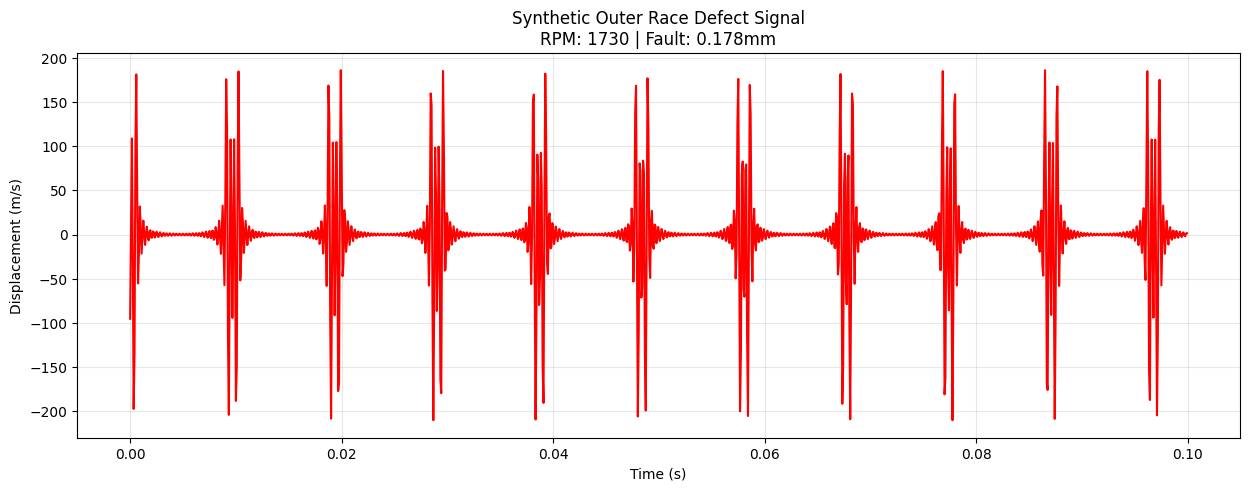

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Parameters
rpm_val = 1730
fault_mm = 0.178  # Approx 0.007 inches
fault_type = 'outer'

# Calculation
df_modes = get_bearing_natural_frequencies()
coeffs = calculate_tandon_coefficients(fault_mm, rpm_val, fault_type)
t, signal = calculate_outer_race_acceleration(coeffs, df_modes, duration_sec=0.1)

# Plot
plt.figure(figsize=(15, 5))
plt.plot(t, signal, color='red')
plt.title(f'Synthetic Outer Race Defect Signal\nRPM: {rpm_val} | Fault: {fault_mm}mm')
plt.xlabel('Time (s)')
plt.ylabel('Displacement (m/s)')
plt.grid(True, alpha=0.3)
plt.show()

### Deslocamento para falha na pista interna

In [34]:
import numpy as np

def calculate_inner_race_acceleration(
    coeffs, 
    df_modes, 
    duration_sec=1.0, 
    fs_hz=12000, 
    N_harmonics_defect=30,  
    M_harmonics_sideband=7, 
    S_harmonics_pulse=15
):
    """
    Calcula a ACELERAÇÃO a(t) para falha na PISTA INTERNA.
    Matematicamente: a(t) = d²y/dt² -> Multiplica cada termo espectral por -(omega^2).
    """
    
    # 1. Setup
    t = np.arange(0, duration_sec, 1/fs_hz)
    acc_time = np.zeros_like(t) # Sinal de aceleração
    
    # Constantes e Frequências
    Z = 9
    f_defect = coeffs['frequencies']['defect_freq_hz']
    f_shaft = coeffs['frequencies']['shaft_freq_hz']
    w_id = 2 * np.pi * f_defect
    w_s  = 2 * np.pi * f_shaft
    
    Po = coeffs['Po']
    Fo = coeffs['Fo']
    get_Pr = coeffs['Pr']
    get_Fs = coeffs['Fs']

    # 2. Compliância (Mantida igual - define a magnitude do deslocamento base)
    structural_compliance = 0.0
    df_outer = df_modes[df_modes['Race'] == 'Outer']
    if df_outer.empty:
        structural_compliance = 1.0e-8 
    else:
        for _, row in df_outer.iterrows():
            structural_compliance += 1.0 / (row['Mass_kg'] * (row['Freq_rad_s']**2))

    # 3. Síntese da Aceleração
    for j in range(1, N_harmonics_defect + 1):
        w_carrier = j * w_id
        
        # --- A. Portadora ---
        term_a1 = Z * Po * Fo * structural_compliance
        term_a2 = 0.0
        for s in range(1, S_harmonics_pulse + 1):
            Fs = get_Fs(s)
            term_a2 += (Z * Po * Fs / 2.0) * structural_compliance
        
        A_j = term_a1 + term_a2
        
        # *** MUDANÇA AQUI: Converter Deslocamento -> Aceleração ***
        # a(t) = -w² * A * cos(wt)
        acc_time += - (w_carrier**2) * A_j * np.cos(w_carrier * t)
        
        # --- B. Bandas Laterais ---
        for r in range(1, M_harmonics_sideband + 1):
            # Frequências
            w_sb_upper = w_carrier + (r * w_s)
            w_sb_lower = np.abs(w_carrier - (r * w_s))
            
            Pr = get_Pr(r)
            
            # Amplitude de Deslocamento (B_jr)
            term_b1 = (Z * Pr * Fo / 2.0) * structural_compliance
            term_b2 = 0.0
            for s in range(1, S_harmonics_pulse + 1):
                Fs = get_Fs(s)
                term_b2 += (Z * Pr * Fs / 4.0) * structural_compliance
            B_jr = term_b1 + term_b2
            
            # *** MUDANÇA AQUI: Multiplica cada banda por sua frequência ao quadrado ***
            acc_time += - (w_sb_upper**2) * B_jr * np.cos(w_sb_upper * t)
            acc_time += - (w_sb_lower**2) * B_jr * np.cos(w_sb_lower * t)

    return t, acc_time

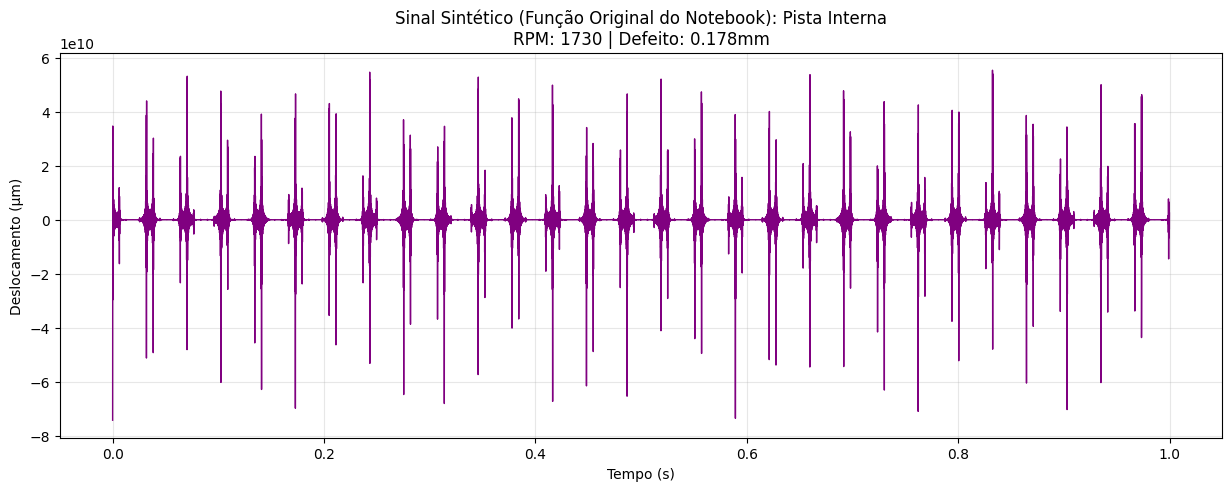

In [35]:
rpm = 1730
fault_mm = 0.178 # 0.007"

# 1. Calcula modos e coeficientes
df_modes = get_bearing_natural_frequencies()
coeffs = calculate_tandon_coefficients(fault_mm, rpm, 'inner')

# 2. CHAMA A FUNÇÃO (Gera sinal de Deslocamento)
t, y_disp = calculate_inner_race_acceleration(coeffs, df_modes)

# 3. Plotagem
plt.figure(figsize=(15, 5))
plt.plot(t, y_disp * 1e6, color='purple', linewidth=1) # Em micrômetros
plt.title(f"Sinal Sintético (Função Original do Notebook): Pista Interna\nRPM: {rpm} | Defeito: {fault_mm}mm")
plt.xlabel("Tempo (s)")
plt.ylabel("Deslocamento (µm)")
plt.grid(True, alpha=0.3)
plt.show()

### Aceleração para falha na esfera

## Cálculo dos atributos

In [12]:
import numpy as np
import pandas as pd
from scipy.stats import skew

# =============================================================================
# BLOCO 3: EXTRAÇÃO DE FEATURES E CRIAÇÃO DOS DATAFRAMES FINAIS (ATUALIZADO)
# =============================================================================

# --- 1. FUNÇÕES PARA CÁLCULO DOS ATRIBUTOS ---

# --- DOMÍNIO DO TEMPO ---
def calcular_tf2_std(sinal):
    return np.std(sinal)

def calcular_tf3_rms(sinal):
    return np.sqrt(np.mean(sinal**2))

def calcular_tf4_fator_forma(sinal):
    rms = calcular_tf3_rms(sinal)
    media_abs = np.mean(np.abs(sinal))
    return rms / media_abs if media_abs != 0 else 0

# --- DOMÍNIO DA FREQUÊNCIA ---
def calcular_features_frequencia(sinal, taxa_amostral):
    N = len(sinal)
    if N == 0: return 0, 0, 0
    espectro = np.abs(np.fft.fft(sinal)[0:N//2])
    freqs = np.fft.fftfreq(N, 1 / taxa_amostral)[:N//2]
    soma_espectro = np.sum(espectro)
    if soma_espectro == 0: return 0, 0, 0
    ff2_freq_central = np.sum(freqs * espectro) / soma_espectro
    ff3_rms_freq = np.sqrt(np.sum((freqs**2) * espectro) / soma_espectro)
    ff4_std_freq = np.sqrt(np.sum(((freqs - ff2_freq_central)**2) * espectro) / soma_espectro)
    numerador_ff5 = np.sum(((freqs - ff2_freq_central)**3) * espectro) / soma_espectro
    ff5_assimetria = numerador_ff5 / (ff4_std_freq**3) if ff4_std_freq != 0 else 0
    return ff2_freq_central, ff3_rms_freq, ff5_assimetria

# ******************************************************************************
# *** NOVA FUNÇÃO ADICIONADA AQUI ***
def calcular_freq_pico_range(sinal, taxa_amostral, min_freq=50, max_freq=200):
    """Calcula a frequência com a maior amplitude (pico) em um range específico."""
    N = len(sinal)
    if N == 0:
        return 0

    # Calcula a FFT e as frequências correspondentes
    espectro = np.abs(np.fft.fft(sinal)[0:N//2])
    freqs = np.fft.fftfreq(N, 1 / taxa_amostral)[:N//2]

    # Cria uma máscara booleana para o range de frequência desejado
    range_mask = (freqs >= min_freq) & (freqs <= max_freq)

    # Filtra as frequências e o espectro para o range de interesse
    freqs_filtradas = freqs[range_mask]
    espectro_filtrado = espectro[range_mask]

    # Verifica se existe algum valor no espectro filtrado
    if len(espectro_filtrado) == 0:
        return 0 # Retorna 0 se não houver componentes de frequência no range

    # Encontra o índice do pico (valor máximo) no espectro filtrado
    indice_pico = np.argmax(espectro_filtrado)

    # Retorna a frequência correspondente a esse pico
    freq_pico = freqs_filtradas[indice_pico]

    return freq_pico
# ******************************************************************************


# --- FUNÇÃO PRINCIPAL DE EXTRAÇÃO (ATUALIZADA) ---
def extrair_todas_features(sinal, taxa_amostral):
    # Features anteriores
    tf2 = calcular_tf2_std(sinal)
    tf3 = calcular_tf3_rms(sinal)
    tf4 = calcular_tf4_fator_forma(sinal)
    ff2, ff3, ff5 = calcular_features_frequencia(sinal, taxa_amostral)

    # *** CÁLCULO DA NOVA FEATURE ***
    ff_pico_range = calcular_freq_pico_range(sinal, taxa_amostral, min_freq=50, max_freq=200)

    # Retorna o dicionário com a nova feature incluída
    return {
        'TF2_std': tf2, 'TF3_rms': tf3, 'TF4_fator_forma': tf4,
        'FF2_freq_central': ff2, 'FF3_rms_freq': ff3, 'FF5_assimetria_espectral': ff5,
        'FF_pico_50_200Hz': ff_pico_range # *** NOVA FEATURE ADICIONADA AQUI ***
    }


# =============================================================================
# --- 2. PROCESSAMENTO DO CONJUNTO DE TREINO (O CÓDIGO AQUI NÃO MUDA) ---
# =============================================================================
print("--- Iniciando extração de atributos do conjunto de TREINO ---")
lista_de_features_treino = []
for linha in df_sinais_treino.itertuples():
    features = extrair_todas_features(linha.sinal_final, TAXA_AMOSTRAL)
    features['tipo_falha_adicionada'] = linha.tipo_falha_adicionada
    features['rpm'] = linha.rpm
    features['multiplicador_amplitude'] = linha.multiplicador_amplitude
    features['fase_adicionada_rad'] = linha.fase_adicionada_rad
    features['base_normal'] = linha.base_normal
    lista_de_features_treino.append(features)

df_treino = pd.DataFrame(lista_de_features_treino)
print(f"Extração concluída! {len(df_treino)} amostras no df_treino.")

# =============================================================================
# --- 3. PROCESSAMENTO DO CONJUNTO DE TESTE (O CÓDIGO AQUI NÃO MUDA) ---
# =============================================================================
print("\n--- Iniciando extração de atributos do conjunto de TESTE ---")
lista_de_features_teste = []
for chave, df_segmento in dicionario_teste.items():
    sinal = df_segmento['amplitude'].values
    features = extrair_todas_features(sinal, TAXA_AMOSTRAL)
    features['tipo_falha_adicionada'] = df_segmento['tipo_falha'].iloc[0]
    features['rpm'] = df_segmento['rotacao_rpm'].iloc[0]
    features['arquivo_origem'] = df_segmento['arquivo_origem'].iloc[0]
    lista_de_features_teste.append(features)

df_teste = pd.DataFrame(lista_de_features_teste)
print(f"Extração concluída! {len(df_teste)} amostras no df_teste.")

# --- 4. EXIBIÇÃO DOS RESULTADOS ---
print("\n\n--- AMOSTRA DO df_treino (DADOS TRATADOS PARA TREINAMENTO) ---")
print(df_treino.head())
print("\n--- INFORMAÇÕES DO df_treino ---")
df_treino.info()

print("\n\n--- AMOSTRA DO df_teste (DADOS TRATADOS PARA TESTE) ---")
print(df_teste.head())
print("\n--- INFORMAÇÕES DO df_teste ---")
df_teste.info()

--- Iniciando extração de atributos do conjunto de TREINO ---
Extração concluída! 17390 amostras no df_treino.

--- Iniciando extração de atributos do conjunto de TESTE ---
Extração concluída! 2897 amostras no df_teste.


--- AMOSTRA DO df_treino (DADOS TRATADOS PARA TREINAMENTO) ---
    TF2_std   TF3_rms  TF4_fator_forma  FF2_freq_central  FF3_rms_freq  \
0  0.070003  0.071239         1.266737       1705.195192   2274.701036   
1  0.069856  0.071094         1.261392       1706.235559   2278.259140   
2  0.069692  0.070933         1.261013       1707.604441   2278.588253   
3  0.069963  0.071199         1.261307       1705.362608   2276.421048   
4  0.089851  0.090989         1.430602       2257.752506   2788.311502   

   FF5_assimetria_espectral  FF_pico_50_200Hz tipo_falha_adicionada   rpm  \
0                  0.916930         90.820312         Pista Externa  1730   
1                  0.914737         90.820312         Pista Externa  1730   
2                  0.915977         90.

## Salva CSV

In [13]:
# =============================================================================
# BLOCO 4: SALVAR OS DATAFRAMES FINAIS EM CSV (COM CAMINHO ESPECÍFICO)
# =============================================================================

import os

# Caminho de saída EXATO fornecido por você
caminho_base_output = r'C:\Users\vinic\OneDrive\Documentos\Graduação\TG\Dataset\TCC'

# Cria o diretório se ele não existir
if not os.path.exists(caminho_base_output):
    os.makedirs(caminho_base_output)
    print(f"Diretório criado em: {caminho_base_output}")

# Define os nomes dos arquivos
caminho_csv_treino = os.path.join(caminho_base_output, 'df_treino_features.csv')
caminho_csv_teste = os.path.join(caminho_base_output, 'df_teste_features.csv')

try:
    # Salva o DataFrame de treino
    df_treino.to_csv(caminho_csv_treino, index=False)
    print(f"\nDataFrame de TREINO (features) salvo com sucesso em:")
    print(f"{caminho_csv_treino}")

    # Salva o DataFrame de teste
    df_teste.to_csv(caminho_csv_teste, index=False)
    print(f"\nDataFrame de TESTE (features) salvo com sucesso em:")
    print(f"{caminho_csv_teste}")

except NameError:
    print("\nERRO: Os DataFrames 'df_treino' ou 'df_teste' não foram encontrados.")
    print("Certifique-se de que o Bloco 3 foi executado com sucesso antes de salvar.")
except Exception as e:
    print(f"\nOcorreu um erro inesperado ao salvar os arquivos: {e}")


DataFrame de TREINO (features) salvo com sucesso em:
C:\Users\vinic\OneDrive\Documentos\Graduação\TG\Dataset\TCC\df_treino_features.csv

DataFrame de TESTE (features) salvo com sucesso em:
C:\Users\vinic\OneDrive\Documentos\Graduação\TG\Dataset\TCC\df_teste_features.csv
